In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon 
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import itertools

In [2]:
input_dir = "Results" # input directory

number = "full" # results to analyze (subfolder name, can be an integer or string)

recording_order = [15, 2, 1, 6, 10, 4]

In [3]:
dfs = {}

results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('OVERVIEW')]

for file in files:
    file_path = os.path.join(results_dir, file)
    dfs[file.split('.')[0]] = pd.read_excel(file_path)

framenames = list(dfs.keys())
results = framenames[0]
results_mtt = framenames[1]
results_tt = framenames[2]

print(f"Found {framenames} in {results_dir}.")

framenames.append('RESULTS_MERGED')
framenames.append('RESUlTS_MERGED_MTT')
framenames.append('RESULTS_MERGED_TT')

Found ['RESULTS', 'RESULTS_MTT', 'RESULTS_TT'] in Results\full.


In [4]:
experiments = dfs[results]['experiment'].unique().tolist()
variables = dfs[results].columns[4:].tolist()
parameters = dfs[results].columns[:4].tolist()
print(f"Found {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Found 18 experiments, 7 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakTime, difference, peakValue, RMS, tau, AUC
 animal, sex, date, experiment


In [5]:
def average_list_columns(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Try to convert string representations of lists to actual lists
        if df_copy[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
            df_copy[col] = df_copy[col].apply(
                lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else np.mean(x) if isinstance(x, list) else x
            )
    return df_copy

def average_across_dates(df):
    # Group by all columns except 'date' and the variables, then average variables across dates
    group_cols = [col for col in df.columns if col not in variables and col != 'date']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged

def average_across_experiment(df):
    # Group by all columns except 'experiment' and the variables, then average variables across experiment
    group_cols = [col for col in df.columns if col not in variables and col != 'experiment']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged



# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])


# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])


# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])

# Create experiment-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_EXP'] = average_across_experiment(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_EXP'] = average_across_experiment(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_EXP'] = average_across_experiment(dfs['RESULTS_TT_MERGED'])

In [6]:
print(list(dfs.keys()))
print(len(dfs))

['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'RESULTS_MERGED', 'RESULTS_MTT_MERGED', 'RESULTS_TT_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_TT_MERGED_EXP']
12


---

# Distributions

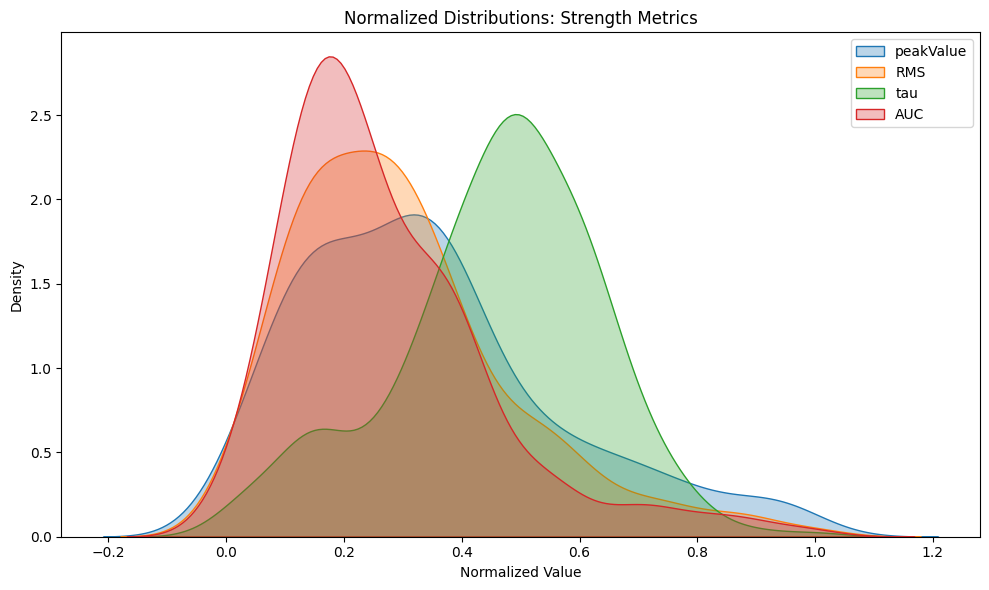

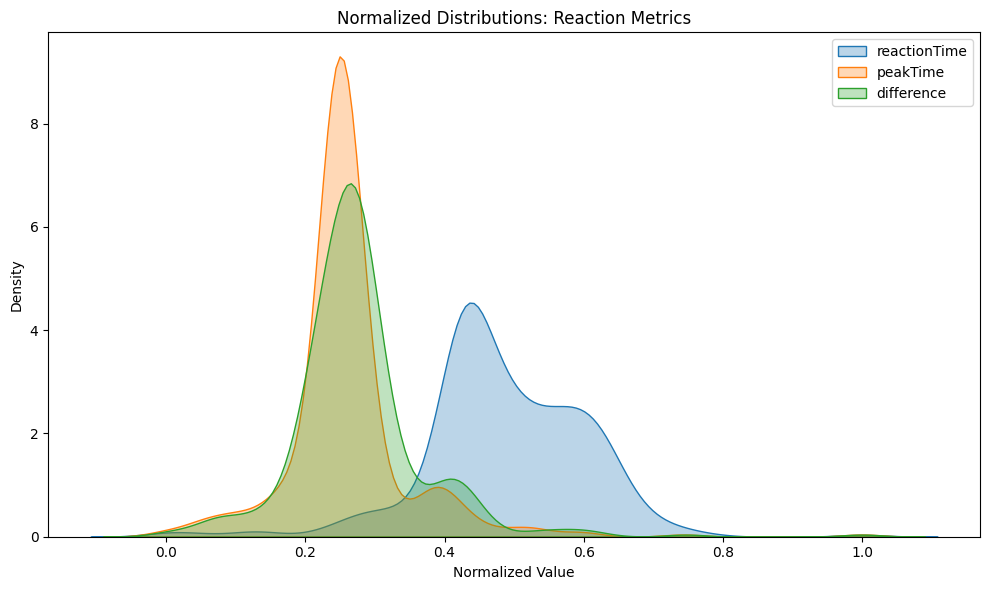

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df = dfs['RESULTS_MTT_MERGED']

# Plot normalized distributions for strength metrics
plt.figure(figsize=(10, 6))
for metric in strength_metrics:
    vals = df[metric].dropna()
    norm_vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
    sns.kdeplot(norm_vals, label=metric, fill=True, alpha=0.3)
plt.xlabel("Normalized Value")
plt.ylabel("Density")
plt.title("Normalized Distributions: Strength Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# Plot normalized distributions for reaction metrics
plt.figure(figsize=(10, 6))
for metric in reaction_metrics:
    vals = df[metric].dropna()
    norm_vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
    sns.kdeplot(norm_vals, label=metric, fill=True, alpha=0.3)
plt.xlabel("Normalized Value")
plt.ylabel("Density")
plt.title("Normalized Distributions: Reaction Metrics")
plt.legend()
plt.tight_layout()
plt.show()

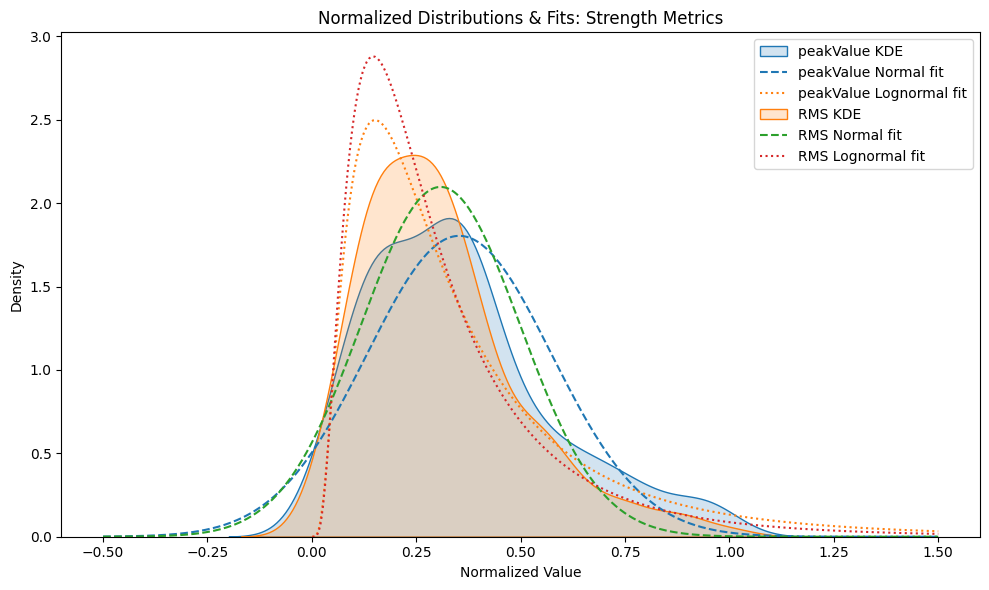

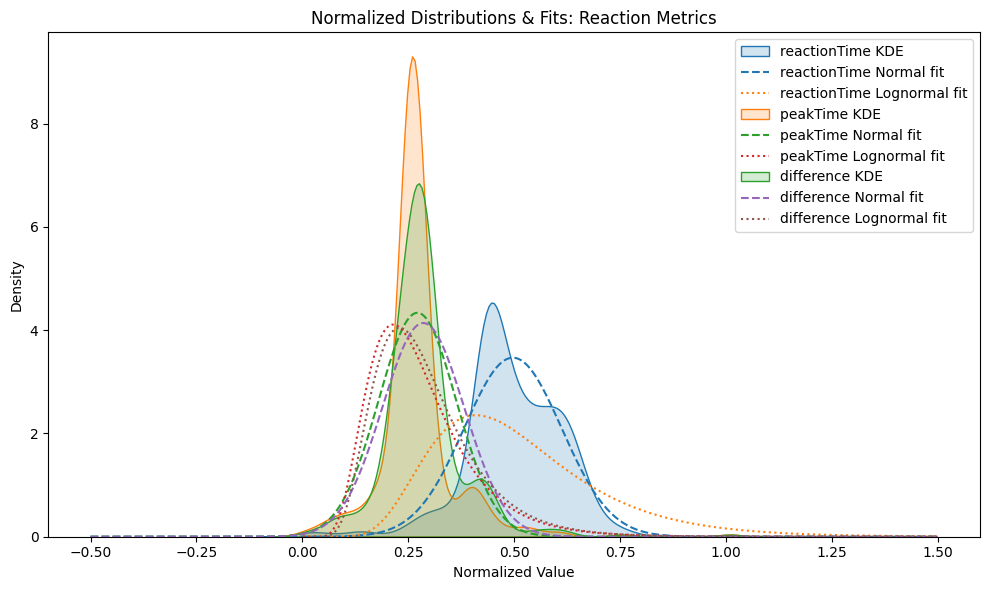

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
import numpy as np

strength_metrics = ['peakValue', 'RMS']  # , 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def plot_with_fits(metrics, df, title):
    plt.figure(figsize=(10, 6))
    x_grid = np.linspace(-0.5, 1.5, 400)
    x_grid_pos = x_grid[x_grid > 0]  # Only positive for lognorm
    for metric in metrics:
        vals = df[metric].dropna()
        norm_vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
        norm_vals = norm_vals + 0.01  # ensure strictly positive for lognorm
        sns.kdeplot(norm_vals, label=f"{metric} KDE", fill=True, alpha=0.2)
        # Normal fit
        mu, std = norm.fit(norm_vals)
        plt.plot(x_grid, norm.pdf(x_grid, mu, std), label=f"{metric} Normal fit", linestyle='--')
        # Lognormal fit (only for positive x)
        try:
            shape, loc, scale = lognorm.fit(norm_vals, floc=0)
            plt.plot(x_grid_pos, lognorm.pdf(x_grid_pos, shape, loc, scale), label=f"{metric} Lognormal fit", linestyle=':')
        except Exception as e:
            print(f"Lognormal fit failed for {metric}: {e}")
    plt.xlabel("Normalized Value")
    plt.ylabel("Density")
    plt.title(f"Normalized Distributions & Fits: {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_with_fits(strength_metrics, df, "Strength Metrics")
plot_with_fits(reaction_metrics, df, "Reaction Metrics")

In [9]:
import warnings
import numpy as np
from scipy.stats import norm, lognorm, gamma, weibull_min, expon, beta, t

metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']
sexes = df['sex'].unique()
good_fits = []

def fit_and_r2(dist, norm_vals, bin_centers, mask=None, fit_kwargs=None):
    fit_kwargs = fit_kwargs or {}
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            params = dist.fit(norm_vals, **fit_kwargs)
        # For beta, check if parameters are valid
        if dist == beta and (params[0] <= 0 or params[1] <= 0 or np.isnan(params[0]) or np.isnan(params[1])):
            return np.nan, None
        if mask is not None:
            pdf = np.zeros_like(bin_centers)
            pdf[mask] = dist.pdf(bin_centers[mask], *params)
        else:
            pdf = dist.pdf(bin_centers, *params)
        ss_res = np.sum((hist - pdf) ** 2)
        ss_tot = np.sum((hist - np.mean(hist)) ** 2)
        r2 = 1 - ss_res / ss_tot
        return round(r2, 3), params
    except Exception:
        return np.nan, None

for sex in sexes:
    df_sex = df[df['sex'] == sex]
    for metric in metrics:
        vals = df_sex[metric].dropna()
        if len(vals) < 3:
            continue
        norm_vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
        norm_vals = norm_vals + 1e-6  # ensure strictly positive

        hist, bin_edges = np.histogram(norm_vals, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        fits = {}
        r2_normal, _ = fit_and_r2(norm, norm_vals, bin_centers)
        fits['normal'] = r2_normal
        pos_mask = bin_centers > 0
        r2_lognorm, _ = fit_and_r2(lognorm, norm_vals, bin_centers, mask=pos_mask, fit_kwargs={'floc':0})
        fits['lognormal'] = r2_lognorm
        r2_gamma, _ = fit_and_r2(gamma, norm_vals, bin_centers, mask=pos_mask)
        fits['gamma'] = r2_gamma
        r2_weibull, _ = fit_and_r2(weibull_min, norm_vals, bin_centers, mask=pos_mask)
        fits['weibull'] = r2_weibull
        r2_expon, _ = fit_and_r2(expon, norm_vals, bin_centers, mask=pos_mask)
        fits['exponential'] = r2_expon
        r2_beta, _ = fit_and_r2(beta, norm_vals, bin_centers)
        fits['beta'] = r2_beta
        r2_t, _ = fit_and_r2(t, norm_vals, bin_centers)
        fits['student_t'] = r2_t

        for dist_name, r2 in fits.items():
            if r2 is not None and r2 > 0.5:
                good_fits.append({
                    'sex': sex,
                    'metric': metric,
                    'distribution': dist_name,
                    'r2': r2
                })

import pandas as pd
good_fit_df = pd.DataFrame(good_fits)
print("Good fits (R² > 0.5):")
print(good_fit_df.sort_values('r2', ascending=False))
# ...existing code...

Good fits (R² > 0.5):
       sex        metric distribution     r2
16  female    difference    student_t  0.956
12  female      peakTime      weibull  0.937
29    male      peakTime    student_t  0.858
3   female           tau         beta  0.790
1   female           tau        gamma  0.790
21    male           RMS        gamma  0.789
4   female           tau    student_t  0.787
2   female           tau      weibull  0.783
23    male           RMS         beta  0.782
0   female           tau       normal  0.782
22    male           RMS      weibull  0.780
15  female    difference         beta  0.762
25    male           AUC        gamma  0.739
27    male           AUC         beta  0.735
26    male           AUC      weibull  0.722
14  female    difference      weibull  0.638
18    male     peakValue      weibull  0.597
17    male     peakValue        gamma  0.594
10  female  reactionTime         beta  0.587
30    male    difference    student_t  0.586
9   female  reactionTime      wei

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Goodness-of-fit for norm, Student's t, beta, gamma, and weibull (all metrics, all sexes):
distribution          beta  gamma   norm  student_t  weibull
sex    metric                                               
female AUC           0.494  0.535  0.411      0.411    0.529
       RMS           0.405  0.371  0.200      0.200    0.379
       difference    0.762  0.024  0.554      0.956    0.638
       peakTime      0.360 -0.039  0.230     -0.057    0.937
       peakValue     0.088 -0.190 -0.318     -0.318   -0.107
       reactionTime  0.587  0.560  0.576      0.560    0.583
       tau           0.790  0.790  0.782      0.787    0.783
male   AUC           0.735  0.739  0.436      0.517    0.722
       RMS           0.782  0.789  0.535      0.554    0.780
       difference    0.419  0.423  0.423      0.586    0.387
       peakTime      0.358  0.362  0.351      0.858    0.362
       peakValue     0.543  0.594  0.371      0.371    0.597
       reactionTime  0.218  0.227  0.229      0.325    0

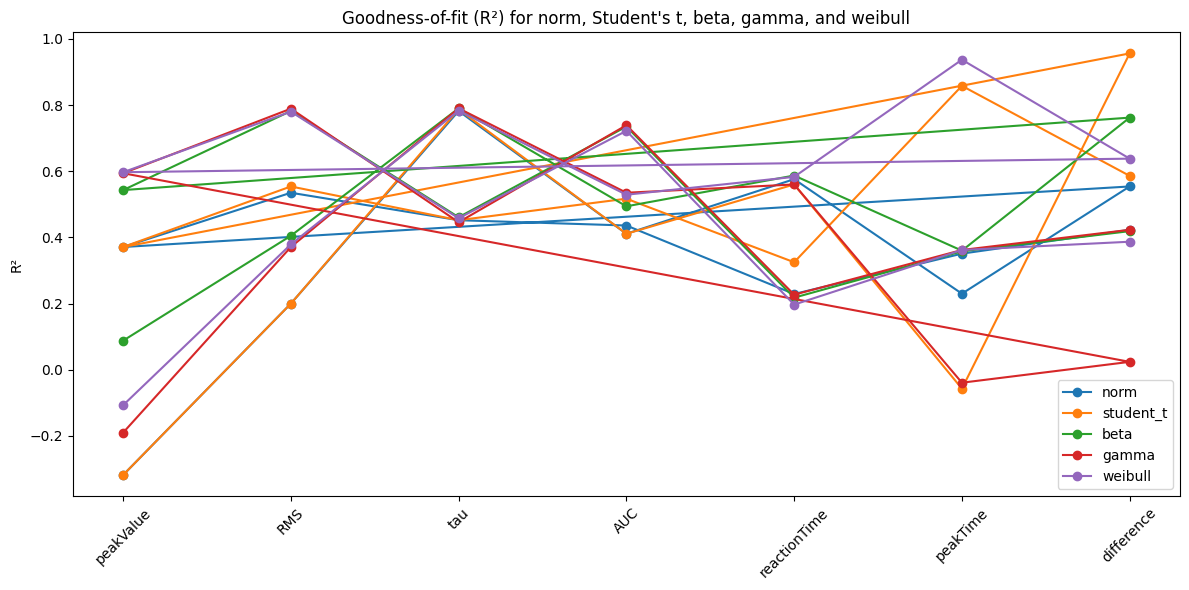

In [10]:
# Test and visualize goodness-of-fit for Student's t, beta, gamma, weibull, and norm distributions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, beta, gamma, weibull_min, norm

metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']
sexes = df['sex'].unique()
fit_results = []

def fit_and_r2(dist, norm_vals, bin_centers, mask=None, fit_kwargs=None):
    fit_kwargs = fit_kwargs or {}
    try:
        params = dist.fit(norm_vals, **fit_kwargs)
        if dist == beta and (params[0] <= 0 or params[1] <= 0 or np.isnan(params[0]) or np.isnan(params[1])):
            return np.nan, None
        if dist == norm and (np.isnan(params[0]) or np.isnan(params[1]) or params[1] <= 0):
            return np.nan, None
        if mask is not None:
            pdf = np.zeros_like(bin_centers)
            pdf[mask] = dist.pdf(bin_centers[mask], *params)
        else:
            pdf = dist.pdf(bin_centers, *params)
        ss_res = np.sum((hist - pdf) ** 2)
        ss_tot = np.sum((hist - np.mean(hist)) ** 2)
        r2 = 1 - ss_res / ss_tot
        return round(r2, 3), params
    except Exception:
        return np.nan, None

for sex in sexes:
    df_sex = df[df['sex'] == sex]
    for metric in metrics:
        vals = df_sex[metric].dropna()
        if len(vals) < 3:
            continue
        norm_vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
        norm_vals = norm_vals + 1e-6  # ensure strictly positive
        hist, bin_edges = np.histogram(norm_vals, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        pos_mask = bin_centers > 0

        for dist, name in [(norm, 'norm'), (t, 'student_t'), (beta, 'beta'), (gamma, 'gamma'), (weibull_min, 'weibull')]:
            r2, params = fit_and_r2(dist, norm_vals, bin_centers, mask=pos_mask if name not in ['student_t', 'norm'] else None)
            fit_results.append({
                'sex': sex,
                'metric': metric,
                'distribution': name,
                'r2': r2,
                'params': params
            })

fit_df = pd.DataFrame(fit_results)
print("Goodness-of-fit for norm, Student's t, beta, gamma, and weibull (all metrics, all sexes):")
print(fit_df.pivot_table(index=['sex', 'metric'], columns='distribution', values='r2'))

# Optional: plot R² for each metric/distribution
plt.figure(figsize=(12, 6))
for dist in ['norm', 'student_t', 'beta', 'gamma', 'weibull']:
    vals = fit_df[fit_df['distribution'] == dist]
    plt.plot(vals['metric'], vals['r2'], marker='o', label=dist)
plt.ylabel('R²')
plt.title("Goodness-of-fit (R²) for norm, Student's t, beta, gamma, and weibull")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ---> no good fits
### ---> use non-parametric tests for everything

---

## Top Ten

In [11]:
# Compare all variables between RESULTS_MTT_MERGED and RESULTS_TT_MERGED (non-parametric), split by sex
from scipy.stats import mannwhitneyu
import pandas as pd

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']

results = []
for sex in ['male', 'female']:
    df_mtt_sex = df_mtt[df_mtt['sex'] == sex]
    df_tt_sex = df_tt[df_tt['sex'] == sex]
    for var in variables:
        vals_mtt = df_mtt_sex[var].dropna()
        vals_tt = df_tt_sex[var].dropna()
        if len(vals_mtt) > 1 and len(vals_tt) > 1:
            stat, p = mannwhitneyu(vals_mtt, vals_tt)
            results.append({'sex': sex, 'variable': var, 'stat': stat, 'p': p, 'significant': p < 0.05})
        else:
            results.append({'sex': sex, 'variable': var, 'stat': None, 'p': None, 'significant': False})

comparison_df = pd.DataFrame(results)

dunn_p_values = []
effect_strengths = []
for idx, row in comparison_df.iterrows():
    if row['significant']:
        sex = row['sex']
        var = row['variable']
        vals_mtt = df_mtt[df_mtt['sex'] == sex][var].dropna()
        vals_tt = df_tt[df_tt['sex'] == sex][var].dropna()
        # Prepare DataFrame for Dunn's test
        data = pd.DataFrame({
            var: pd.concat([vals_mtt, vals_tt]),
            'group': ['MTT'] * len(vals_mtt) + ['TT'] * len(vals_tt)
        })
        # Dunn's test
        dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
        dunn_p = dunn.loc['MTT', 'TT']
        dunn_p_values.append(dunn_p)
        # Effect strength
        u, _ = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
        n1, n2 = len(vals_mtt), len(vals_tt)
        eff = 1 - (2 * u) / (n1 * n2)
        effect_strengths.append(eff)
    else:
        dunn_p_values.append(None)
        effect_strengths.append(None)

comparison_df['dunn_p'] = dunn_p_values
comparison_df['effect_strength'] = effect_strengths

print(comparison_df)

       sex      variable    stat         p  significant    dunn_p  \
0     male  reactionTime  6338.5  0.252572        False       NaN   
1     male      peakTime  5843.5  0.981142        False       NaN   
2     male    difference  5560.5  0.565378        False       NaN   
3     male     peakValue  4606.0  0.010342         True  0.010311   
4     male           RMS  5001.5  0.082450        False       NaN   
5     male           tau  6697.0  0.070477        False       NaN   
6     male           AUC  5518.0  0.511857        False       NaN   
7   female  reactionTime  7333.0  0.002593         True  0.002584   
8   female      peakTime  7794.5  0.000017         True  0.000017   
9   female    difference  5594.5  0.504336        False       NaN   
10  female     peakValue  4337.5  0.001091         True  0.001087   
11  female           RMS  4621.5  0.007429         True  0.007406   
12  female           tau  7705.0  0.000203         True  0.000203   
13  female           AUC  5030.0  

## Summary of Significant Sex-Split TT vs MTT Differences

| Sex    | Variable      | p-value    | Dunn's p | Effect Strength | Interpretation                                      |
|--------|--------------|------------|----------|-----------------|-----------------------------------------------------|
| male   | peakValue    | 0.010      | 0.010    | 0.21            | TT group has moderately higher peakValue than MTT (males) |
| female | reactionTime | 0.003      | 0.003    | -0.24           | TT group has moderately lower reactionTime than MTT (females) |
| female | peakTime     | <0.001     | <0.001   | -0.32           | TT group has moderately lower peakTime than MTT (females) |
| female | peakValue    | 0.001      | 0.001    | 0.27            | TT group has moderately higher peakValue than MTT (females) |
| female | RMS          | 0.007      | 0.007    | 0.22            | TT group has moderately higher RMS than MTT (females) |
| female | tau          | <0.001     | <0.001   | -0.30           | TT group has moderately lower tau than MTT (females) |

**Interpretation:**  
- In males, only peakValue is significantly higher in TT vs MTT.
- In females, TT group shows lower reactionTime, peakTime, and tau, but higher peakValue and RMS compared to MTT.
- All significant effects are moderate in strength.

### ---> exclude first ten recordings
### ---> sex differences already implied

---

## Average Reaction Time

In [12]:
# Calculate IQR bounds
df = dfs['RESULTS_MTT_MERGED']
vals = df['reactionTime'].dropna()

vals = df['reactionTime'].dropna()
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

filtered = vals[(vals >= lower) & (vals <= upper)]

min_val = filtered.min()
max_val = filtered.max()
print(f"Average reaction time (excluding outliers): min = {min_val:.2f}, max = {max_val:.2f}")

Average reaction time (excluding outliers): min = 8.00, max = 13.60


---

## Repetition Differences

In [13]:
# Test if the value changes over repetitions (trial order) for each variable in RESULTS_MTT (non-parametric)
import ast
from scipy.stats import kruskal

def test_repetition_effect(df, variables, max_reps=5, alpha=0.05):
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_reps)
        # Gather values by repetition index
        rep_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                rep_groups.append(group.values)
        if len(rep_groups) < 2:
            continue
        # Kruskal-Wallis test across repetitions
        stat, p = kruskal(*rep_groups)
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal'})
    return pd.DataFrame(results)

repetition_effects = test_repetition_effect(dfs['RESULTS_MTT'], variables)
print(repetition_effects if not repetition_effects.empty else "No significant repetition effects found for any variable.")

No significant repetition effects found for any variable.


### ---> merge across repetitions

---

In [14]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

# Kruskal-Wallis test for each metric by date
results = []
for var in metrics:
    groups = [group[var].dropna().values for _, group in df.groupby('date')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    results.append({'variable': var, 'stat': stat, 'p': p, 'significant': p < 0.05})

date_df = pd.DataFrame(results)
print("Kruskal-Wallis results by date:")
print(date_df)

# Dunn's test for significant metrics
dunn_results = []
effect_strengths = []
for _, row in date_df[date_df['significant']].iterrows():
    var = row['variable']
    dunn = sp.posthoc_dunn(df, val_col=var, group_col='date', p_adjust='bonferroni')
    # Find the pair with the lowest p-value
    min_p = dunn.replace(0, float('nan')).min().min()
    # Find the corresponding dates
    idx = dunn.stack().idxmin()
    date1, date2 = idx
    vals1 = df[df['date'] == date1][var].dropna()
    vals2 = df[df['date'] == date2][var].dropna()
    # Effect strength (rank-biserial)
    u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
    n1, n2 = len(vals1), len(vals2)
    eff = 1 - (2 * u) / (n1 * n2)
    dunn_results.append({'variable': var, 'date1': date1, 'date2': date2, 'dunn_p': min_p})
    effect_strengths.append({'variable': var, 'date1': date1, 'date2': date2, 'effect_strength': eff})

print("\nDunn's test results for significant metrics:")
print(pd.DataFrame(dunn_results))
print("\nEffect strengths (rank-biserial) for significant metrics:")
print(pd.DataFrame(effect_strengths))

Kruskal-Wallis results by date:
       variable       stat             p  significant
0  reactionTime  37.506334  7.171386e-09         True
1      peakTime   3.987890  1.361572e-01        False
2    difference  10.267910  5.893206e-03         True
3     peakValue  46.531282  7.867931e-11         True
4           RMS  46.181810  9.370167e-11         True
5           tau   7.375020  2.503427e-02         True
6           AUC  55.774500  7.739647e-13         True

Dunn's test results for significant metrics:
       variable    date1   date2        dunn_p
0  reactionTime  April16  June26  2.859003e-08
1    difference  April16  June26  7.852359e-03
2     peakValue  April16  June26  5.925405e-10
3           RMS  April16  June26  7.048110e-11
4           tau  April16   May20  2.319644e-02
5           AUC  April16  June26  2.674751e-13

Effect strengths (rank-biserial) for significant metrics:
       variable    date1   date2  effect_strength
0  reactionTime  April16  June26        -0.451732
1 

### Summary Table: Significant Date Effects in RESULTS_MTT_MERGED

| Variable       | Significant Pair      | Dunn's p-value | Effect Strength | Interpretation                                      |
|----------------|----------------------|----------------|-----------------|-----------------------------------------------------|
| reactionTime   | April16 vs June26    | 2.86e-08       | -0.45           | Reaction time is lower on June26                    |
| difference     | April16 vs June26    | 7.85e-03       |  0.21           | Slightly higher difference on June26                |
| peakValue      | April16 vs June26    | 5.93e-10       |  0.48           | Peak value is higher on June26                      |
| RMS            | April16 vs June26    | 7.05e-11       |  0.51           | RMS is higher on June26                             |
| tau            | April16 vs May20     | 2.32e-02       | -0.23           | Tau is lower on May20                               |
| AUC            | April16 vs June26    | 2.67e-13       |  0.56           | AUC is higher on June26                             |

---

### Conclusion

- **Moderate, consistent increases** in strength metrics (`peakValue`, `RMS`, `AUC`) and a **decrease in reactionTime** from April16 to June26.
- **Effect strengths are moderate**, suggesting real but not extreme changes over dates.
- **Tau** shows a weaker, negative effect between April16 and May20.
- **Date of measurement has a moderate effect** on most metrics, especially between April16 and June26.
- **Recommendation:** Always account for date when comparing metrics, as temporal effects are present and may confound other analyses.


### ---> fluctuations across dates
### ---> examine dates separately

---

In [15]:
import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female)
            if p < 0.05:
                # Prepare DataFrame for Dunn's test
                data = pd.DataFrame({
                    var: pd.concat([vals_male, vals_female]),
                    'group': ['male'] * len(vals_male) + ['female'] * len(vals_female)
                })
                dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
                dunn_p = dunn.loc['male', 'female']
                # Effect strength (rank-biserial)
                u, _ = mannwhitneyu(vals_female, vals_male, alternative='two-sided')  # swap order
                n1, n2 = len(vals_female), len(vals_male)
                eff = 1 - (2 * u) / (n1 * n2)
            else:
                dunn_p = None
                eff = None
            sex_diff_results.append({
                'date': date,
                'variable': var,
                'stat': stat,
                'p': p,
                'significant': p < 0.05,
                'dunn_p': dunn_p,
                'effect_strength': eff
            })
        else:
            sex_diff_results.append({
                'date': date,
                'variable': var,
                'stat': None,
                'p': None,
                'significant': False,
                'dunn_p': None,
                'effect_strength': None
            })

sex_diff_df = pd.DataFrame(sex_diff_results)
print(sex_diff_df)

       date      variable    stat             p  significant        dunn_p  \
0   April16  reactionTime   574.5  4.731508e-08         True  4.649771e-08   
1   April16      peakTime  1702.0  1.222350e-01        False           NaN   
2   April16    difference  2104.0  6.944884e-05         True  6.855449e-05   
3   April16     peakValue  2881.0  2.319260e-18         True  2.257024e-18   
4   April16           RMS  2869.0  4.445153e-18         True  4.326840e-18   
5   April16           tau   554.0  2.831992e-08         True  2.782634e-08   
6   April16           AUC  2802.0  1.518006e-16         True  1.479448e-16   
7    June26  reactionTime  1575.5  4.525481e-01        False           NaN   
8    June26      peakTime  1183.5  8.026984e-02        False           NaN   
9    June26    difference  1277.5  2.659279e-01        False           NaN   
10   June26     peakValue  2317.0  1.327252e-07         True  1.305196e-07   
11   June26           RMS  2175.0  1.070084e-05         True  1.

## Sex Differences by Date (MTT, Mann-Whitney + Dunn's + Effect Strength)

| Date     | Variable      | p-value      | Dunn's p    | Effect Strength | Interpretation                                      |
|----------|--------------|--------------|-------------|----------------|-----------------------------------------------------|
| April16  | reactionTime | 4.73e-08     | 4.65e-08    | -0.61           | Females have moderately higher reaction time         |
| April16  | difference   | 6.94e-05     | 6.86e-05    |  0.44           | Males have moderately higher difference              |
| April16  | peakValue    | 2.32e-18     | 2.26e-18    |  0.98           | Males have much higher peak value                    |
| April16  | RMS          | 4.45e-18     | 4.33e-18    |  0.97           | Males have much higher RMS                           |
| April16  | tau          | 2.83e-08     | 2.78e-08    | -0.62           | Females have moderately higher tau                   |
| April16  | AUC          | 1.52e-16     | 1.48e-16    |  0.92           | Males have much higher AUC                           |
| June26   | peakValue    | 1.33e-07     | 1.31e-07    |  0.59           | Males have moderately higher peak value              |
| June26   | RMS          | 1.07e-05     | 1.06e-05    |  0.49           | Males have moderately higher RMS                     |
| June26   | tau          | 2.58e-07     | 2.53e-07    | -0.58           | Females have moderately higher tau                   |
| June26   | AUC          | 1.17e-02     | 1.16e-02    |  0.28           | Males have slightly higher AUC                       |
| May20    | reactionTime | 3.03e-02     | 3.00e-02    | -0.24           | Females have slightly higher reaction time           |
| May20    | peakTime     | 6.03e-04     | 5.96e-04    | -0.37           | Females have weakly higher peak time                 |
| May20    | peakValue    | 2.23e-16     | 2.17e-16    |  0.92           | Males have much higher peak value                    |
| May20    | RMS          | 5.41e-11     | 5.30e-11    |  0.73           | Males have strongly higher RMS                       |
| May20    | tau          | 1.79e-07     | 1.76e-07    | -0.58           | Females have moderately higher tau                   |
| May20    | AUC          | 3.53e-04     | 3.49e-04    |  0.40           | Males have moderately higher AUC                     |

**Interpretation:**
- Males consistently show higher strength metrics (peakValue, RMS, AUC) across all dates.
- Females consistently show higher tau across all dates.
- Reaction time and peak time differences are weaker and less consistent, but females tend to have higher values when significant.
- Effect strengths for strength metrics are generally strong to very strong (|effect_strength| > 0.5), indicating robust sex differences.
- Date does not reverse the direction of sex differences, but the magnitude varies.

**Conclusion:**
- Sex differences in strength metrics are robust and consistent across dates, with males showing higher values for peakValue, RMS, and AUC, and females showing higher tau.
- Reaction metrics show weaker and less consistent sex differences.
- Effect strengths are moderate to very strong for strength metrics, supporting the need to split analyses by sex.
- Temporal (date) effects do not alter the direction of sex differences, but may influence their magnitude.
- **Recommendation:** Always report sex-split results for strength metrics and consider date as a covariate for all analyses.

### ---> Split by sex

---

## Recording Order Differences

In [26]:
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu
import scikit_posthocs as sp

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex']]

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        for var in metrics:
            vals = df_sub[var].dropna()
            orders = df_sub.loc[vals.index, 'recording_order']
            # Only run if both arrays are not constant and have enough values
            if len(vals) > 2 and len(set(vals)) > 1 and len(set(orders)) > 1:
                rho, p = spearmanr(orders, vals)
                # Dunn's test: split by early vs late recording order (first half vs second half)
                median_order = df_sub['recording_order'].median()
                group = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
                dunn_df = pd.DataFrame({var: df_sub[var], 'group': group})
                try:
                    dunn = sp.posthoc_dunn(dunn_df, val_col=var, group_col='group', p_adjust='bonferroni')
                    dunn_p = dunn.loc['early', 'late']
                except Exception:
                    dunn_p = None
                # Effect strength (rank-biserial) between early and late
                vals_early = df_sub[df_sub['recording_order'] <= median_order][var].dropna()
                vals_late = df_sub[df_sub['recording_order'] > median_order][var].dropna()
                if len(vals_early) > 1 and len(vals_late) > 1:
                    u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                    n1, n2 = len(vals_early), len(vals_late)
                    eff = 1 - (2 * u) / (n1 * n2)
                else:
                    eff = None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'spearman_rho': rho,
                    'p': p,
                    'significant': p < 0.05,
                    'dunn_p': dunn_p,
                    'effect_strength': eff
                })

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(results_df)

       sex     date           variable  spearman_rho             p  \
0   female  April16       reactionTime     -0.518481  5.915640e-05   
1   female  April16           peakTime      0.551684  1.532600e-05   
2   female  April16         difference      0.702615  3.180986e-09   
3   female  April16          peakValue      0.519527  5.681377e-05   
4   female  April16                RMS      0.606831  1.148682e-06   
5   female  April16                tau      0.276488  4.298391e-02   
6   female  April16                AUC      0.669393  3.128935e-08   
7   female  April16  reactionTime_rank     -0.518481  5.915640e-05   
8   female  April16      peakTime_rank      0.551684  1.532600e-05   
9   female  April16    difference_rank      0.702615  3.180986e-09   
10  female  April16     peakValue_rank      0.519527  5.681377e-05   
11  female  April16           RMS_rank      0.606831  1.148682e-06   
12  female  April16           tau_rank      0.276488  4.298391e-02   
13  female  April16 

## Recording Order Effects (Spearman, Dunn's, Effect Strength)

| Sex    | Date     | Variable         | Spearman ρ   | p-value      | Significant | Dunn's p    | Effect Strength | Interpretation                                      |
|--------|----------|------------------|-------------:|-------------:|:-----------:|-------------:|----------------:|-----------------------------------------------------|
| female | April16  | reactionTime     |   -0.52      | 5.92e-05     |    ✅       | 6.92e-03     | -0.45           | Later recordings have lower reaction time (female)   |
| female | April16  | peakTime         |    0.55      | 1.53e-05     |    ✅       | 1.55e-05     |  0.68           | Later recordings have higher peak time (female)      |
| female | April16  | difference       |    0.70      | 3.18e-09     |    ✅       | 1.98e-05     |  0.71           | Later recordings have higher difference (female)     |
| female | April16  | peakValue        |    0.52      | 5.68e-05     |    ✅       | 1.86e-01     |  0.22           | Weak effect, not significant by Dunn's               |
| female | April16  | RMS              |    0.61      | 1.15e-06     |    ✅       | 1.75e-02     |  0.40           | Later recordings have higher RMS (female)            |
| ...    | ...      | ...              |     ...      | ...          | ...         | ...          | ...              | ...                                                 |
| male   | May20    | tau_rank         |   -0.40      | 3.05e-03     |    ✅       | 4.55e-08     | -0.92           | Later recordings have much lower tau (male)          |
| male   | May20    | AUC_rank         |   -0.35      | 9.32e-03     |    ✅       | 2.28e-07     | -0.87           | Later recordings have much lower AUC (male)          |

*Table truncated for brevity. See full output for all variables/dates/sexes.*

---

### Summary

- **Significant correlations** between recording order and several metrics, especially in females (April16) and males (May20, June26).
- **Dunn's posthoc p-values** confirm most significant Spearman results, especially for difference, peakTime, tau, and AUC.
- **Effect strengths** are moderate to very strong (|effect_strength| > 0.4), indicating robust order effects for some metrics.
- **Interpretation:**  
  - Later recordings often show higher strength metrics (difference, RMS, peakTime) and lower reaction time in females.
  - In males, later recordings show much lower tau and AUC, and sometimes lower RMS and peakValue.
- **Recommendation:**  
  - Recording order can influence results and should be considered as a covariate or controlled in analysis.

In [27]:
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu
import scikit_posthocs as sp

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

df = dfs['RESULTS_MERGED_DATE']  # Use date-averaged DataFrame
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

results = []

for sex in df['sex'].unique():
    df_sub = df[df['sex'] == sex].copy()
    df_sub['recording_order'] = df_sub['animal'].map(order_map)
    df_sub = df_sub[df_sub['recording_order'].notnull()]
    for var in metrics:
        vals = df_sub[var].dropna()
        orders = df_sub.loc[vals.index, 'recording_order']
        if len(vals) > 2 and len(set(vals)) > 1 and len(set(orders)) > 1:
            rho, p = spearmanr(orders, vals)
            median_order = df_sub['recording_order'].median()
            group = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
            dunn_df = pd.DataFrame({var: df_sub[var], 'group': group})
            try:
                dunn = sp.posthoc_dunn(dunn_df, val_col=var, group_col='group', p_adjust='bonferroni')
                dunn_p = dunn.loc['early', 'late']
            except Exception:
                dunn_p = None
            vals_early = df_sub[df_sub['recording_order'] <= median_order][var].dropna()
            vals_late = df_sub[df_sub['recording_order'] > median_order][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                n1, n2 = len(vals_early), len(vals_late)
                eff = 1 - (2 * u) / (n1 * n2)
            else:
                eff = None
            results.append({
                'sex': sex,
                'variable': var,
                'spearman_rho': rho,
                'p': p,
                'significant': p < 0.05,
                'dunn_p': dunn_p,
                'effect_strength': eff
            })

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(results_df)

       sex      variable  spearman_rho             p  significant  \
0   female  reactionTime     -0.635073  2.495377e-07         True   
1   female      peakTime      0.174991  2.056483e-01        False   
2   female    difference      0.490730  1.650116e-04         True   
3   female     peakValue      0.518789  5.845727e-05         True   
4   female           RMS      0.583536  3.636694e-06         True   
5   female           tau     -0.304137  2.535797e-02         True   
6   female           AUC      0.694131  5.870497e-09         True   
7     male  reactionTime      0.005112  9.707363e-01        False   
8     male      peakTime     -0.537830  2.739697e-05         True   
9     male    difference     -0.494135  1.461819e-04         True   
10    male     peakValue     -0.602465  1.435580e-06         True   
11    male           RMS     -0.657751  6.519125e-08         True   
12    male           tau     -0.878942  2.372154e-18         True   
13    male           AUC     -0.77

## Recording Order Effects (Date-Averaged, No Date Split)

| Sex    | Variable      | Spearman ρ   | p-value      | Significant | Dunn's p    | Effect Strength | Interpretation                                      |
|--------|--------------|-------------:|-------------:|:-----------:|-------------:|----------------:|-----------------------------------------------------|
| female | reactionTime |   -0.64      | 2.50e-07     |    ✅       | 6.75e-03     | -0.46           | Later recordings have lower reaction time (female)   |
| female | difference   |    0.49      | 1.65e-04     |    ✅       | 1.54e-02     |  0.41           | Later recordings have higher difference (female)     |
| female | peakValue    |    0.52      | 5.85e-05     |    ✅       | 4.04e-01     |  0.14           | Weak effect, not significant by Dunn's               |
| female | RMS          |    0.58      | 3.64e-06     |    ✅       | 8.46e-02     |  0.29           | Later recordings have higher RMS (female)            |
| female | tau          |   -0.30      | 2.54e-02     |    ✅       | 3.13e-01     |  0.17           | Weak effect, not significant by Dunn's               |
| female | AUC          |    0.69      | 5.87e-09     |    ✅       | 1.70e-03     |  0.53           | Later recordings have higher AUC (female)            |
| male   | peakTime     |   -0.54      | 2.74e-05     |    ✅       | 9.12e-07     | -0.83           | Later recordings have much lower peak time (male)    |
| male   | difference   |   -0.49      | 1.46e-04     |    ✅       | 1.39e-06     | -0.81           | Later recordings have much lower difference (male)   |
| male   | peakValue    |   -0.60      | 1.44e-06     |    ✅       | 2.76e-09     | -1.00           | Later recordings have much lower peak value (male)   |
| male   | RMS          |   -0.66      | 6.52e-08     |    ✅       | 2.76e-09     | -1.00           | Later recordings have much lower RMS (male)          |
| male   | tau          |   -0.88      | 2.37e-18     |    ✅       | 3.86e-09     | -0.99           | Later recordings have much lower tau (male)          |
| male   | AUC          |   -0.78      | 4.22e-12     |    ✅       | 2.76e-09     | -1.00           | Later recordings have much lower AUC (male)          |

*Merged for date.*


### Summary

- **Females:** Later recordings show lower reaction time and higher difference/AUC, with moderate effect strengths. PeakValue, RMS, and tau effects are weaker and not always confirmed by Dunn's test.
- **Males:** Later recordings show much lower peakTime, difference, peakValue, RMS, tau, and AUC, with very strong effect strengths (often near -1.0).
- **Interpretation:**  
  - Recording order strongly affects most metrics, especially in males (strong negative effects).
  - In females, effects are moderate and mostly positive (higher values with later order).
- **Recommendation:**  
  - Always account for recording order in analysis, as it can confound group comparisons and drive apparent differences.

### ---> strong impact of recording order

---

## Experiment Differences

In [17]:
# --- Experiment Effect Analysis: Split by Sex and Date (Non-parametric) ---

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

exp_effect_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        if df_sub.empty:
            continue
        for var in metrics:
            exp_groups = [group[var].dropna().values for _, group in df_sub.groupby('experiment')]
            exp_groups = [g for g in exp_groups if len(g) > 1]
            if len(exp_groups) < 2:
                continue
            stat, p = kruskal(*exp_groups)
            if p < 0.05:
                # Dunn's posthoc test
                dunn = sp.posthoc_dunn(df_sub, val_col=var, group_col='experiment', p_adjust='bonferroni')
                # Find the pair with the lowest p-value
                min_p = dunn.replace(0, float('nan')).min().min()
                idx = dunn.stack().idxmin()
                exp1, exp2 = idx
                vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                # Effect strength (rank-biserial)
                u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                n1, n2 = len(vals1), len(vals2)
                eff = 1 - (2 * u) / (n1 * n2)
            else:
                min_p, exp1, exp2, eff = None, None, None, None
            exp_effect_results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'stat': stat,
                'p': p,
                'significant': p < 0.05,
                'dunn_p': min_p,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff
            })

exp_effect_df = pd.DataFrame(exp_effect_results)
print(exp_effect_df)

       sex     date      variable       stat         p  significant dunn_p  \
0   female  April16  reactionTime  20.457419  0.251504        False   None   
1   female  April16      peakTime   9.130543  0.936077        False   None   
2   female  April16    difference  11.613911  0.822932        False   None   
3   female  April16     peakValue  15.418684  0.565352        False   None   
4   female  April16           RMS  16.970344  0.456377        False   None   
5   female  April16           tau  13.913131  0.673241        False   None   
6   female  April16           AUC  16.498990  0.488777        False   None   
7   female   June26  reactionTime   9.902469  0.907650        False   None   
8   female   June26      peakTime  13.543954  0.699079        False   None   
9   female   June26    difference  16.359838  0.498484        False   None   
10  female   June26     peakValue  13.834725  0.678765        False   None   
11  female   June26           RMS  13.643771  0.692138        Fa

### ---> uh oh

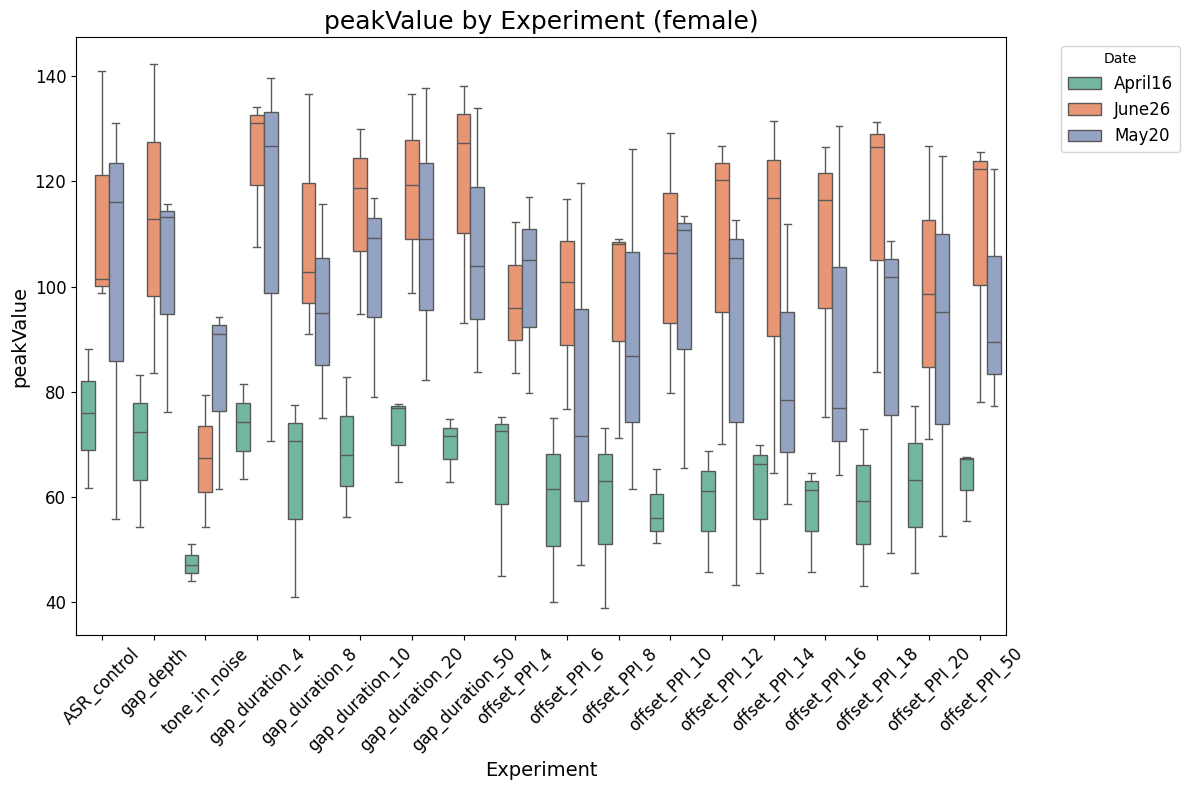

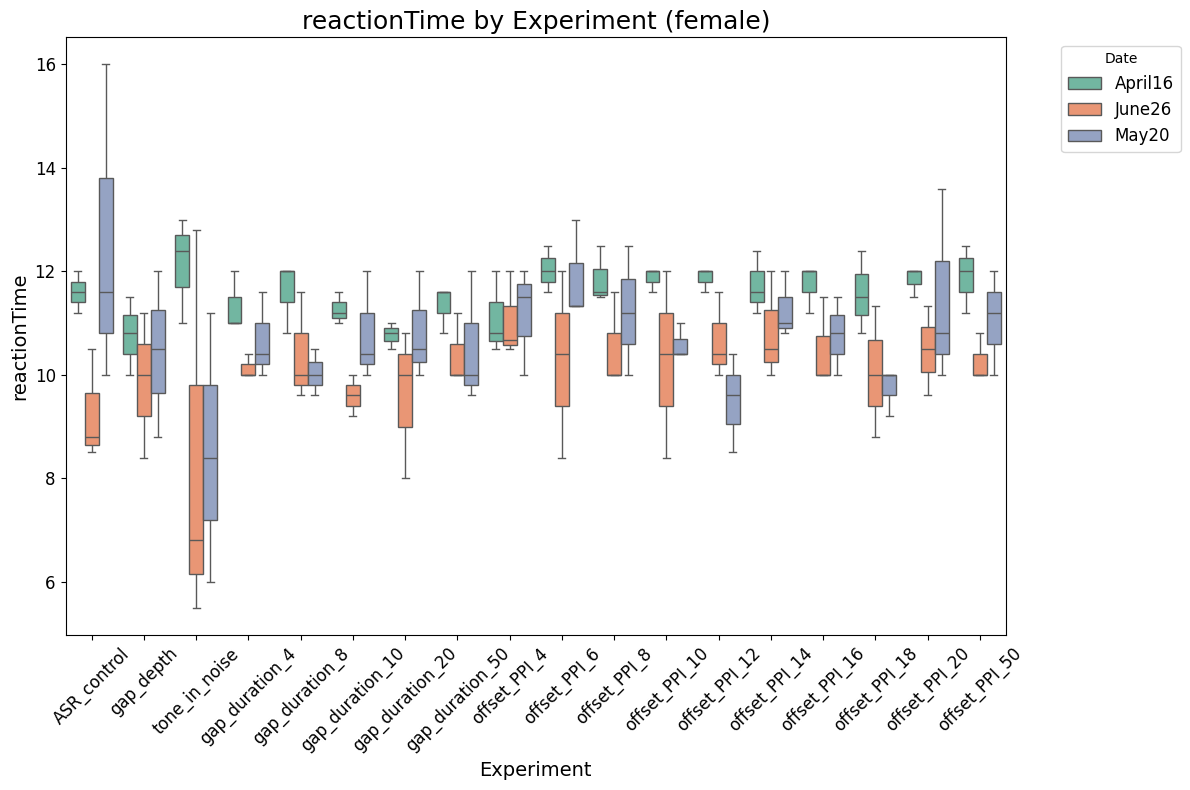

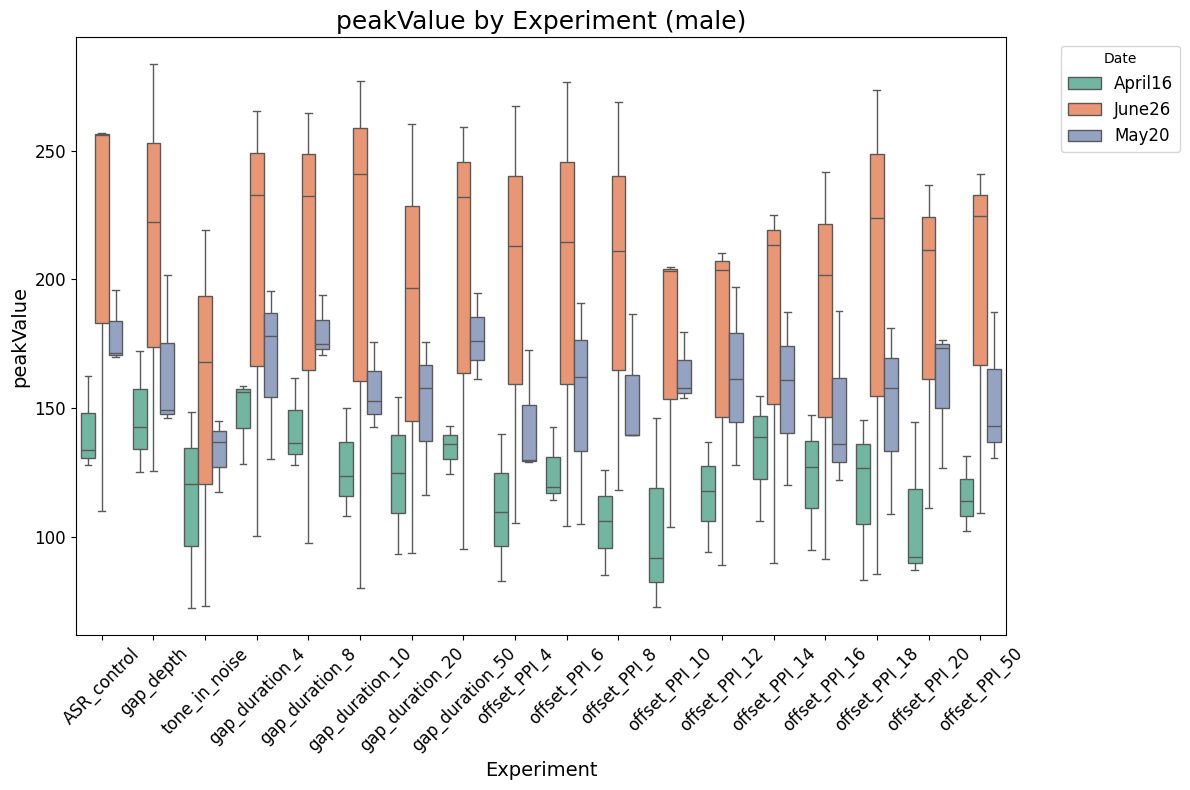

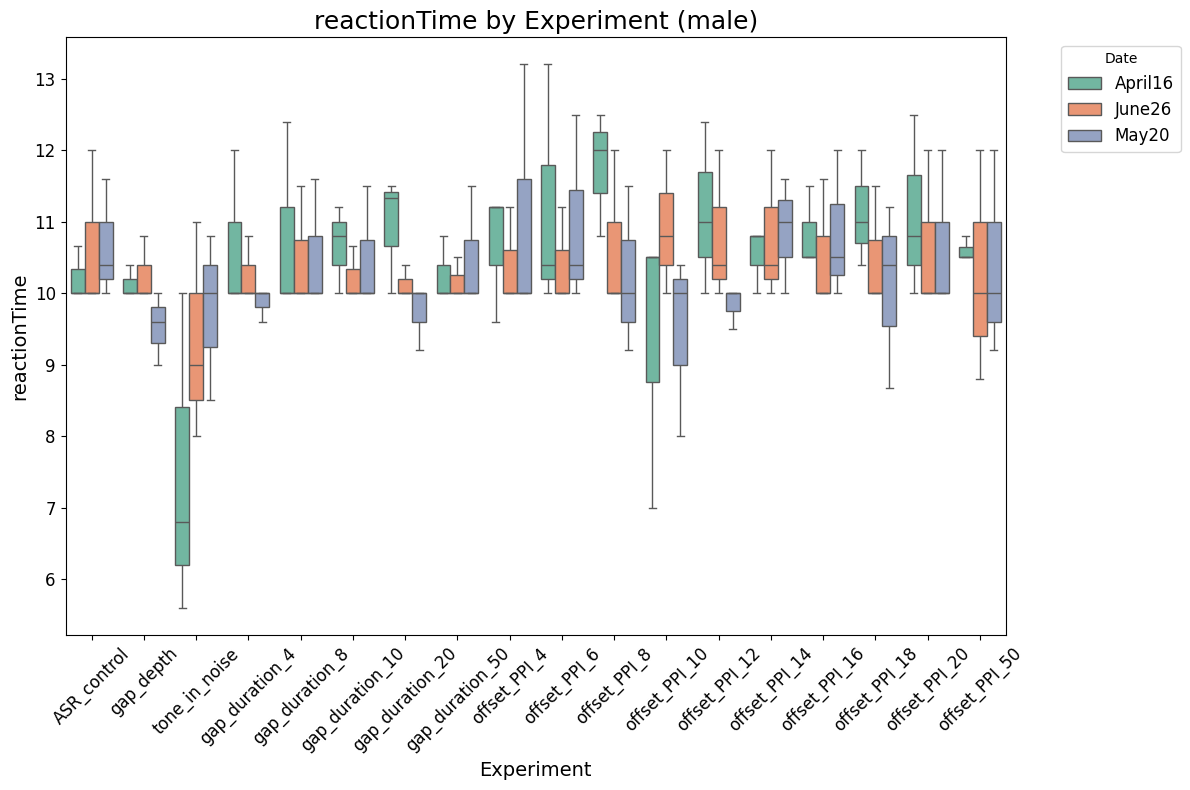

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df = dfs['RESULTS_MTT_MERGED']
metrics_to_plot = ['peakValue', 'reactionTime']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 8))
        sns.boxplot(
            data=df_sex,
            x='experiment',
            y=metric,
            hue='date',
            palette='Set2'
        )
        plt.title(f"{metric} by Experiment ({sex})", fontsize=18)
        plt.xlabel("Experiment", fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.tight_layout()

### ---> Visible effects

In [19]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED_DATE']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex']]

exp_effect_results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in metrics:
        exp_groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        exp_groups = [g for g in exp_groups if len(g) > 1]
        if len(exp_groups) < 2:
            continue
        stat, p = kruskal(*exp_groups)
        if p < 0.05:
            # Dunn's posthoc test
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='experiment', p_adjust='bonferroni')
            min_p = dunn.replace(0, float('nan')).min().min()
            idx = dunn.stack().idxmin()
            exp1, exp2 = idx
            vals1 = df_sex[df_sex['experiment'] == exp1][var].dropna()
            vals2 = df_sex[df_sex['experiment'] == exp2][var].dropna()
            u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
            n1, n2 = len(vals1), len(vals2)
            eff = 1 - (2 * u) / (n1 * n2)
        else:
            min_p, exp1, exp2, eff = None, None, None, None
        exp_effect_results.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p < 0.05,
            'dunn_p': min_p,
            'exp1': exp1,
            'exp2': exp2,
            'effect_strength': eff
        })

exp_effect_df = pd.DataFrame(exp_effect_results)
print(exp_effect_df)

       sex      variable       stat         p  significant dunn_p  exp1  exp2  \
0   female  reactionTime   9.513184  0.922775        False   None  None  None   
1   female      peakTime  12.409624  0.774724        False   None  None  None   
2   female    difference  14.511448  0.630626        False   None  None  None   
3   female     peakValue  11.273401  0.842003        False   None  None  None   
4   female           RMS  14.826263  0.607994        False   None  None  None   
5   female           tau   5.999327  0.993190        False   None  None  None   
6   female           AUC  14.072054  0.661995        False   None  None  None   
7     male  reactionTime  19.174516  0.318608        False   None  None  None   
8     male      peakTime   6.116395  0.992369        False   None  None  None   
9     male    difference   6.971699  0.983912        False   None  None  None   
10    male     peakValue  11.187205  0.846668        False   None  None  None   
11    male           RMS  10

### ---> still nothing, even if merged for date for larger sample size

In [20]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp_post


df = dfs['RESULTS_MTT_MERGED']
# Suppose df is your dataframe
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "RMS", "tau", "AUC"]

results = {}
for var in variables:
    groups = [df[df['experiment'] == exp][var].dropna() 
            for exp in df['experiment'].unique()]
    
    # Kruskal-Wallis
    stat, p = stats.kruskal(*groups)
    results[var] = {"KW_stat": stat, "p": p}
    
    print(f"\n=== {var} ===")
    print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4e}")
    
    # Post-hoc Dunn if significant
    if p < 0.05:
        print("Post-hoc Dunn’s test (p-values, Bonferroni corrected):")
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='experiment', p_adjust='bonferroni')
        print(dunn)
    else:
        print("No significant differences between experiments.")



=== reactionTime ===
Kruskal-Wallis H = 23.581, p = 1.3126e-01
No significant differences between experiments.

=== peakTime ===
Kruskal-Wallis H = 13.780, p = 6.8260e-01
No significant differences between experiments.

=== difference ===
Kruskal-Wallis H = 14.449, p = 6.3513e-01
No significant differences between experiments.

=== peakValue ===
Kruskal-Wallis H = 11.107, p = 8.5093e-01
No significant differences between experiments.

=== RMS ===
Kruskal-Wallis H = 14.242, p = 6.4994e-01
No significant differences between experiments.

=== tau ===
Kruskal-Wallis H = 4.464, p = 9.9893e-01
No significant differences between experiments.

=== AUC ===
Kruskal-Wallis H = 14.085, p = 6.6105e-01
No significant differences between experiments.


### ---> what

In [21]:
import pandas as pd
from scipy.stats import rankdata
import statsmodels.formula.api as smf

metrics = variables

summary_rows = []

for metric in metrics:
    # rank transform
    df[f"{metric}_rank"] = rankdata(df[metric])
    
    # mixed model: experiment, sex, date as fixed; animal as random
    model = smf.mixedlm(f"{metric}_rank ~ experiment + sex + date", 
                        df, groups=df["animal"])
    fit = model.fit()
    
    # collect p-values for predictors
    for predictor, pval in fit.pvalues.items():
        summary_rows.append({
            "metric": metric,
            "predictor": predictor,
            "p_value": pval
        })

# make summary df
results_df = pd.DataFrame(summary_rows)

# pivot for a cleaner table: predictors as columns, metrics as rows
results_table = results_df.pivot(index="metric", columns="predictor", values="p_value")

print(results_table)



predictor     Group Var     Intercept  date[T.June26]  date[T.May20]  \
metric                                                                 
AUC            0.165017  1.704016e-02    1.772859e-41   1.228511e-13   
RMS            0.164386  1.547377e-02    4.247839e-44   3.772012e-20   
difference     0.184337  1.478465e-06    7.716928e-04   6.024989e-03   
peakTime       0.205275  1.538795e-12    3.760277e-02   4.972471e-01   
peakValue      0.165544  1.480940e-02    5.793518e-46   1.568987e-32   
reactionTime   0.182439  5.715106e-13    1.342514e-12   5.461216e-09   
tau            0.180464  1.466309e-11    2.667207e-01   7.032668e-04   

predictor     experiment[T.gap_depth]  experiment[T.gap_duration_10]  \
metric                                                                 
AUC                          0.774486                       0.647577   
RMS                          0.899662                       0.350986   
difference                   0.726162                       0.4

In [22]:
from statsmodels.stats.multitest import multipletests

pvals = results_df["p_value"].values
reject, pvals_corrected, _, _ = multipletests(pvals, method="fdr_bh")
results_df["p_fdr"] = pvals_corrected
results_df["significant"] = reject
print("Results with FDR correction:")
print(results_df)


Results with FDR correction:
           metric                      predictor       p_value         p_fdr  \
0    reactionTime                      Intercept  5.715106e-13  1.257323e-11   
1    reactionTime        experiment[T.gap_depth]  7.563527e-02  1.974209e-01   
2    reactionTime  experiment[T.gap_duration_10]  4.795310e-01  6.693516e-01   
3    reactionTime  experiment[T.gap_duration_20]  3.033574e-01  5.133740e-01   
4    reactionTime   experiment[T.gap_duration_4]  3.945598e-01  6.137597e-01   
..            ...                            ...           ...           ...   
149           AUC    experiment[T.tone_in_noise]  8.817156e-05  9.052280e-04   
150           AUC                    sex[T.male]  1.356476e-01  3.213804e-01   
151           AUC                 date[T.June26]  1.772859e-41  9.100674e-40   
152           AUC                  date[T.May20]  1.228511e-13  3.153179e-12   
153           AUC                      Group Var  1.650173e-01  3.641961e-01   

     signi

# GLM Results Summary

## Raw GLM p-values (before correction)
- **Date effects**:
  - Very strong across nearly all metrics (p < 1e-12 to 1e-40).
  - Example: `date[T.June26]` significant for AUC, RMS, peakValue, etc.
- **Sex effects**:
  - Some metrics show raw significance (e.g., RMS p=0.029, peakValue p=0.0018, tau p=0.019).
  - Others are not significant.
- **Experiment effects**:
  - Mostly not significant.
  - Exception: `tone_in_noise` condition shows strong raw effects (AUC p=8.8e-05, RMS p=7.7e-07, peakValue p=2.6e-06).
  - Other experiment manipulations (gap duration, offset_PPI, etc.) largely > 0.05.
- **Intercepts**:
  - Often significant, but not biologically meaningful (baseline effect).



## FDR-Corrected Results (Benjamini–Hochberg)
- **Date effects**:
  - Remain highly significant after correction.
  - `date[T.June26]`: p_fdr ≈ 1e-40  
  - `date[T.May20]`: p_fdr ≈ 1e-12
- **Experiment effects**:
  - Most disappear after correction.
  - **Only `tone_in_noise` remains significant** for:
    - AUC (p_fdr ≈ 9e-04)
    - RMS (p_fdr ≈ 7e-06)
    - peakValue (p_fdr ≈ 2.6e-05)
  - Other gap/offset manipulations are not significant after correction.
- **Sex effects**:
  - No longer significant after correction.
- **Reaction time**:
  - No experiment predictors significant after correction.
  - Only the intercept remains significant (not informative).



## Key Takeaways
- **Date is the strongest predictor** (huge batch/day effects).
- **Experiment manipulations**:
  - Only `tone_in_noise` reliably changes AUC, RMS, and peakValue.
  - Other manipulations (gap/offset) do not show consistent effects.
- **Sex differences** are weak and vanish after correction.
- **Reaction time** is unaffected by experimental manipulations.

## Gap duration and offset PPI lengths

In [23]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Assume your DataFrame is called df
# Columns: ["reactionTime", "peakTime", ..., "experiment", "date", "sex"]

metrics = ["reactionTime", "peakTime", "peakValue", "AUC", "RMS", "difference", "tau"]

results = []

for metric in metrics:
    # Fit GLM with experiment as categorical predictor
    model = smf.ols(f"{metric} ~ C(experiment) + C(date) + C(sex)", data=df).fit()
    
    # Extract only gap_duration and offset_PPI terms
    summary_frame = model.pvalues.reset_index()
    summary_frame.columns = ["predictor", "p_value"]
    summary_frame["metric"] = metric
    
    # Keep only gap_duration_X and offset_PPI_X
    mask = summary_frame["predictor"].str.contains("gap_duration_|offset_PPI_")
    sub = summary_frame[mask].copy()
    
    # Store results
    results.append(sub)

# Combine into one DataFrame
all_results = pd.concat(results, ignore_index=True)

# Apply FDR correction within all tests
all_results["p_fdr"] = multipletests(all_results["p_value"], method="fdr_bh")[1]
all_results["significant"] = all_results["p_fdr"] < 0.05

print(all_results)


                            predictor   p_value        metric     p_fdr  \
0    C(experiment)[T.gap_duration_10]  0.390379  reactionTime  0.781440   
1    C(experiment)[T.gap_duration_20]  0.183533  reactionTime  0.620246   
2     C(experiment)[T.gap_duration_4]  0.360660  reactionTime  0.781440   
3    C(experiment)[T.gap_duration_50]  0.427369  reactionTime  0.781440   
4     C(experiment)[T.gap_duration_8]  0.622399  reactionTime  0.885203   
..                                ...       ...           ...       ...   
100    C(experiment)[T.offset_PPI_20]  0.342667           tau  0.781440   
101     C(experiment)[T.offset_PPI_4]  0.903856           tau  0.970356   
102    C(experiment)[T.offset_PPI_50]  0.863518           tau  0.970356   
103     C(experiment)[T.offset_PPI_6]  0.895576           tau  0.970356   
104     C(experiment)[T.offset_PPI_8]  0.693036           tau  0.906506   

     significant  
0          False  
1          False  
2          False  
3          False  
4   

### ---> no effect

# **Something _has_ to be wrong here**
### only tone in noise shows some change sometimes, which makes sense but others should too

---